# 泰坦尼克号船员生还预测模型
# ——Python数据分析小组实践
软金特2101班 黄旭达 付会柱 刘干
2022年11月5日

## 科学计算和机器学习函数库调用

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import re

## 数据读取

In [3]:
df = pd.read_csv("data/train.csv")

## 读取后的数据

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 对数据初步浏览

### 部分表头对应意义
* Survived：是否存活（1为真0为假）
* PClass：乘客舱等级(一/二/三等舱位)
* SibSp：堂兄弟/妹个数
* Parch：父母与小孩个数
* Ticket：票号
* Fare：票价
* Cabin：客舱号
* Embarked：登船港口

### 对数据各项情况进行检查
#### 1. 数据分布情况

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### 2.数值类型数据统计情况

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


由上表可知
* Pclass最小值为1，最大值为3，均值为2.3，说明三等舱位的应该是多数
* Age最小值为0.17，最大值为80，均值为29.88，最大最小值需要再观察一下
* Fare最小值为0，最大值为512，std为51，波动较大，需要注意

### 初步浏览的发现
1. Survived 标签列可以看出一共891条训练数据。
其中，数值型数据(int、float类型)包括
* PassenegerId
* Survived
* Pclass
* Age
* SibSp
* Parch
* Fare
**总体数据中，Age、Fare、Cabin 和Embarked 均存在不同程序的缺失，可能会对训练结果造成不良影响，需要进行清洗**
2. 针对数值型数据
* 三等舱位是多数，统计时可以单独作为一个指标与一、二等对立
* 年龄最值需要再观察
* 票价波动较大，可能有特殊数据，需要注意

## 字段分析
分析具体的字段含义，更有利于进行缺失值的填补
Name 列数据是通过逗号分隔开（即Last Name，First Name），可以考虑从中获取信息
例如：同一姓氏的人可能是一个小团体，所以，我们将姓名进行分离。

In [7]:
# 将名和姓分离
df['Last_Name'] = df['Name'].apply(lambda name: name.split(',')[0])
df['First_Name'] = df['Name'].apply(lambda name: name.split(',')[1])

分离后，原有数据的前10条如下：

In [8]:
df[['Name','First_Name','Last_Name']].head(10)

,Name,First_Name,Last_Name
0,"Braund, Mr. Owen Harris",Mr. Owen Harris,Braund
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs. John Bradley (Florence Briggs Thayer),Cumings
2,"Heikkinen, Miss. Laina",Miss. Laina,Heikkinen
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs. Jacques Heath (Lily May Peel),Futrelle
4,"Allen, Mr. William Henry",Mr. William Henry,Allen
5,"Moran, Mr. James",Mr. James,Moran
6,"McCarthy, Mr. Timothy J",Mr. Timothy J,McCarthy
7,"Palsson, Master. Gosta Leonard",Master. Gosta Leonard,Palsson
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs. Oscar W (Elisabeth Vilhelmina Berg),Johnson
9,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs. Nicholas (Adele Achem),Nasser


根据对英语国家文化的学习，了解到姓名前的Title也具有一定信息，经查阅资料和整合后，可知：
* Mr：先生
* Miss、Mlle、Ms：女士（未结婚或没有子女之类的）
* Mrs、Mme：夫人（亦指已婚妇女）
* Master：少爷（小孩，可能也包括一部分未婚成年贵族男性）
* Rev：牧师
* Dr：医生
* Capt、Col、Major：上校、中校、少校（可能属于船上的船长、副船长等船员，故分为一类）
* Don、Dona、Sir（先贵族和有地位的先生或女士）
* Jonkheer、Countess、Lady：乡绅、伯爵（亦指有地位者）

针对本项目背景，可以将人员根据Title划分为如下类别：
* 普通男士和女士
* 特征职业的人士，比如船员、医生、牧师，因为是海难，所以船员可单独分类
* 有地位者、贵族等

综上，我们可以将Title分为下面这几类
* Mr：男士
* Miss、Mlle、Ms、Mrs、Mme：女士
* Rev、Dr：特征职业人员
* Capt、Col、Major：船员
* Master、Don、Dona、Sir、Jonkheer、Countess、Lady：有地位者

所以，将之从姓名数据（First_Name）中单独抽离出来，作为一个新字段。

In [9]:
# 通过正则表达取出Title数据

# 通过正则表达式分离出名称前面的Title标识
df['Title'] = df['First_Name'].apply(lambda first_name: re.search('([A-Za-z]+)\.', first_name, flags=0).group(1))

# 通过分类标准对Title数据进行分类
title_mapping = {'Mr': 1, 'Miss': 2, 'Mlle': 2, 'Ms': 2, 'Mrs': 2, 'Mme': 2,
                 'Rev': 3, 'Dr': 3, 'Col': 4, 'Major': 4, 'Capt': 4,
                 'Master': 5, 'Don': 5, 'Dona': 5, 'Lady': 5, 'Countess': 5, 'Jonkheer': 5, 'Sir': 5,
                }
# 将Title直接量化
df['Title_Type'] = df['Title'].map(title_mapping)

In [10]:
df[['Title_Type','Title','First_Name','Last_Name']].head(10)

,Title_Type,Title,First_Name,Last_Name
0,1,Mr,Mr. Owen Harris,Braund
1,2,Mrs,Mrs. John Bradley (Florence Briggs Thayer),Cumings
2,2,Miss,Miss. Laina,Heikkinen
3,2,Mrs,Mrs. Jacques Heath (Lily May Peel),Futrelle
4,1,Mr,Mr. William Henry,Allen
5,1,Mr,Mr. James,Moran
6,1,Mr,Mr. Timothy J,McCarthy
7,5,Master,Master. Gosta Leonard,Palsson
8,2,Mrs,Mrs. Oscar W (Elisabeth Vilhelmina Berg),Johnson
9,2,Mrs,Mrs. Nicholas (Adele Achem),Nasser


根据对英语国家文化的学习，了解到一种说法，即姓名越长，表示表示家庭底蕴越丰厚，地位也就越高。为检验该说法是否正确，可以在将数据可视化时通过观察指标之间的关联度去确定。
先对字段进行扩充。
首先，直接通过len 函数获取每个名字的长度。

In [11]:
df['Name_Len'] = df['Name'].apply(lambda name: len(name))
df[['Name_Len','Title','Title_Type']].head(10)

,Name_Len,Title,Title_Type
0,23,Mr,1
1,51,Mrs,2
2,22,Miss,2
3,44,Mrs,2
4,24,Mr,1
5,16,Mr,1
6,23,Mr,1
7,30,Master,5
8,49,Mrs,2
9,35,Mrs,2


最后，注意到SibSp和Parch可以表示随行人员数量，参照谚语“众人拾柴火焰高”，将之纳入影响生存结果的指标。
经初步推敲，得出如下公式：

$ CountTeam = SibSp + Parch + 1$

即随行人员数量 = 堂兄弟姐妹 + 长辈和子女 + 自己1人
根据公式对数据进行进一步扩充

In [12]:
df['CountTeam'] = df['SibSp']+df['Parch'] + 1
df[['Name','CountTeam','SibSp','Parch']].head(10)

,Name,CountTeam,SibSp,Parch
0,"Braund, Mr. Owen Harris",2,1,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,1,0
2,"Heikkinen, Miss. Laina",1,0,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,1,0
4,"Allen, Mr. William Henry",1,0,0
5,"Moran, Mr. James",1,0,0
6,"McCarthy, Mr. Timothy J",1,0,0
7,"Palsson, Master. Gosta Leonard",5,3,1
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",3,0,2
9,"Nasser, Mrs. Nicholas (Adele Achem)",2,1,0


## 数据清洗
### 缺失数据处理

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Last_Name        0
First_Name       0
Title            0
Title_Type       0
Name_Len         0
CountTeam        0
dtype: int64

其中Age（缺失177）、Cabin（缺失687）、Embarked（缺失2），下面来对缺失数据挨个处理。

#### 1.Embarked 填充

In [14]:
df.loc[df['Embarked'].isnull(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,First_Name,Title,Title_Type,Name_Len,CountTeam
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,Miss. Amelie,Miss,2,19,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Mrs. George Nelson (Martha Evelyn),Mrs,2,41,1


* 缺失特征：1等船舱的B28客舱的两位女士(一个38岁，一个62岁)
* 填充方式：选择1等船舱的女性登录最多的港口进行填充

In [15]:
df.loc[(df['Pclass'] == 1) & (df['Sex'] == 'female'), 'Embarked'].value_counts()

S    48
C    43
Q     1
Name: Embarked, dtype: int64

所以将这两位归入S入口

In [16]:
df.loc[df['Embarked'].isnull(),'Embarked'] = 'S'

#### 2.Age 填充
使用同等舱位、同一登船港口、同一性别的众数/均值进行填充。

In [17]:
df.loc[df['Age'].isnull(),:].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,First_Name,Title,Title_Type,Name_Len,CountTeam
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,Mr. James,Mr,1,16,1
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Williams,Mr. Charles Eugene,Mr,1,28,1
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Masselmani,Mrs. Fatima,Mrs,2,23,1


In [18]:
def get_age(pclass,embarked,sex,data):
    data = data.loc[(data['Pclass'] == pclass) & (data['Embarked'] == embarked) & (data['Sex'] == sex),]

    if data.size<1:
        pass
    return data['Age'].mode()[0]

df.loc[df['Age'].isnull(),'Age'] = df.loc[df['Age'].isnull(),['Pclass','Embarked','Sex']].apply(lambda info:get_age(info[0],info[1],info[2],df),axis=1)

#### 3.Cabin 填充
缺失值过多，填充的时候并不能保证我们填充的是否正确，不妨将空数据当作一类，非空的当作一类，即，缺失值当做直接置为Null，非空为NotNull。

In [19]:
df.loc[df['Cabin'].isnull(),:].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,First_Name,Title,Title_Type,Name_Len,CountTeam
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,Mr. Owen Harris,Mr,1,23,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,Miss. Laina,Miss,2,22,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,Mr. William Henry,Mr,1,24,1


In [20]:
df['Cabin'] = df['Cabin'].isnull().apply(lambda x:'Null' if x is True else 'NotNull')

In [21]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,First_Name,Title,Title_Type,Name_Len,CountTeam
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Null,S,Braund,Mr. Owen Harris,Mr,1,23,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,NotNull,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,2,51,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Null,S,Heikkinen,Miss. Laina,Miss,2,22,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,NotNull,S,Futrelle,Mrs. Jacques Heath (Lily May Peel),Mrs,2,44,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Null,S,Allen,Mr. William Henry,Mr,1,24,1
5,6,0,3,"Moran, Mr. James",male,2.0,0,0,330877,8.4583,Null,Q,Moran,Mr. James,Mr,1,16,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,NotNull,S,McCarthy,Mr. Timothy J,Mr,1,23,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,Null,S,Palsson,Master. Gosta Leonard,Master,5,30,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,Null,S,Johnson,Mrs. Oscar W (Elisabeth Vilhelmina Berg),Mrs,2,49,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,Null,C,Nasser,Mrs. Nicholas (Adele Achem),Mrs,2,35,2


## 数据可视化
下面对结果进行初步分析并使用matplot做出对应图表。
首先创建图标实例并初始化

In [22]:
# 创建画布并对参数进行设置
fig = plt.figure(figsize=(18,7))
alpha = ALPHA_SCATTER = 0.2
ALPHA_BAR_CHART = 0.55
plt.rcParams['font.sans-serif'] = 'OPPOSans'
plt.rcParams['axes.unicode_minus'] = False

<Figure size 1800x700 with 0 Axes>

### 0.有针对性地绘制图表
本任务目的是根据数据中的特征预测个人是否能够生存，目前数据中的字段以及对应意义如下：
* 定性数据——定类数据和定序数据，主要包括以下字段：
    * PassengerId：乘客id
    * Survived：生还or遇难
    * Pclass：船舱等级
    * Name：乘客姓名
    * Sex：性别
    * SibSp：堂兄弟/妹个数
    * Parch：父母与小孩个数
    * Ticket：船票信息
    * Cabin：客舱
    * Embarked：登船港口
    * CabinType：客舱的分类（新增）
    * Last_Name & First_Name & Title(新增姓名衍生列)
    * Title：姓名的title标识（新增）
    * Title_Type：Title的分类（新增）
    * NameLen：姓名的长度（新增）
    * CountTeam：家庭成员数（新增）
* 定量数据——定距数据和定比数据，主要包括以下字段：
    * Age：年龄
    * Fare：票价

* Pclass、Sex、SibSp、Parch、Embarked类别较少，可以进行条形图可视化
* Age、Ticket为离散数据，可以用折线图、散点图可视化

首先，绘制一个幸存者与遇难者数量对比的条形图。

Text(0.5, 1.0, '生存与遇难人数粗略对比（1 = 生存，0 = 遇难）')

<Figure size 600x400 with 0 Axes>

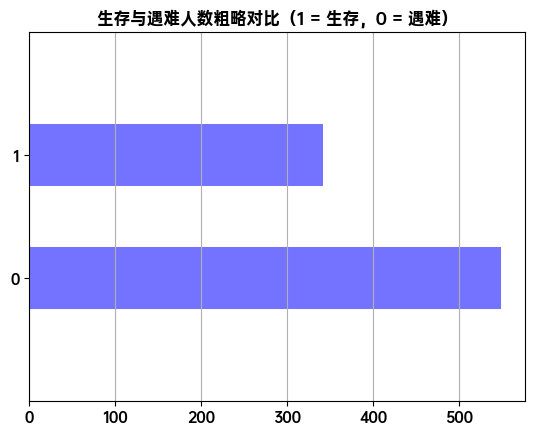

In [23]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind="barh",color="blue", alpha=ALPHA_BAR_CHART)
ax.set_ylim(-1,len(df.Survived.value_counts()))
plt.grid(visible=True, which='major', axis='x')
plt.title("生存与遇难人数粗略对比（1 = 生存，0 = 遇难）")

下面针对各特征字段信息，对生存情况的分布进行绘制。

In [25]:
# 统计图

## 有监督机器学习
针对以上所得的数据以及分析的情况，有监督地展开机器学习